In [471]:
# Imports
import requests
import pandas as pd
from datetime import datetime, timedelta
from datetime import date as dt_date

import time
import json

In [472]:
def fmt(val):
    return f"${val:,.2f}"

In [473]:
from dotenv import load_dotenv
import os

load_dotenv()

STOCK_API_KEY = os.getenv("POLYGON_STOCK_API_KEY")
OPTIONS_API_KEY = os.getenv("POLYGON_OPTIONS_API_KEY")


index = 'SPY'  # Index proxy

# Strategy config
DTE_TARGET = 60
DTE_TOLERANCE = 5  # days
MAX_VEGA_DRIFT = 0.10  # ¬±50%


In [474]:
# Load the Excel file
vega_df = pd.read_excel("Bloomberg_Vega.xlsx")

# Identify metadata columns
meta_cols = ['Underlying Ticker', 'Polygon Ticker', 'Bloomberg Ticker', 'Bloomberg Ticker Equity']

# Manually detect date columns by checking if they can be parsed to datetime
date_cols = []
for col in vega_df.columns:
    if col not in meta_cols:
        try:
            parsed = pd.to_datetime(col)
            date_cols.append(col)
        except:
            continue

# Melt the DataFrame using only date columns
vega_long = vega_df.melt(
    id_vars=['Polygon Ticker'],
    value_vars=date_cols,
    var_name='Date',
    value_name='Vega'
)

# Convert the date strings to actual datetime.date objects
vega_long['Date'] = pd.to_datetime(vega_long['Date'], errors='coerce').dt.date

# Drop rows where date conversion failed
vega_long = vega_long.dropna(subset=['Date'])

# Create a fast MultiIndex lookup table
vega_lookup = vega_long.set_index(['Polygon Ticker', 'Date'])
vega_lookup.head(10)

Vega
Polygon Ticker         Date             
O:SPY250725C00615000   2025-06-23  0.639
O:SPY250725P00615000   2025-06-23  0.599
O:MSFT250725C00495000  2025-06-23  0.568
O:MSFT250725P00495000  2025-06-23  0.559
O:AAPL250725C00200000  2025-06-23  0.239
O:AAPL250725P00200000  2025-06-23  0.239
O:NVDA250725C00157500  2025-06-23  0.117
O:NVDA250725P00157500  2025-06-23  0.079
O:GOOGL250725C00180000 2025-06-23  0.142
O:GOOGL250725P00180000 2025-06-23  0.127

In [475]:
def get_spot_price(ticker, reference_date=None):
    if reference_date:
        date_str = pd.to_datetime(reference_date).strftime("%Y-%m-%d")
        url = f"https://api.polygon.io/v1/open-close/{ticker}/{date_str}?adjusted=true&apiKey={STOCK_API_KEY}"
        print(f"[SPOT] Requesting historical price: {url}")
        res = requests.get(url)
        data = res.json()
        if res.status_code == 200 and 'close' in data:
            return data['close']
        else:
            print(f"‚ö†Ô∏è Historical fallback failed for {ticker} on {date_str}. Response: {data}")
            return None
    else:
        url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/prev?adjusted=true&apiKey={STOCK_API_KEY}"
        res = requests.get(url)
        data = res.json()
        if 'results' in data and len(data['results']) > 0:
            return data['results'][0]['c']
        print(f"[SPOT] Fallback response for {ticker}: {data}")
        return None

    
def format_option(opt):
    if not opt:
        return "None"
    return (
        f"{opt['ticker']} | Strike: {opt['strike_price']} | "
        f"Exp: {opt['expiration_date']} | Type: {opt['contract_type']} | "
        f"Exercise: {opt['exercise_style']} | Multiplier: {opt.get('multiplier', 'N/A')}"
    )




In [476]:
import pandas_market_calendars as mcal
from datetime import datetime, timedelta

def get_nearest_valid_friday(start_date=None, max_shift=10):
    if start_date is None:
        start_date = datetime.utcnow().date()

    nyse = mcal.get_calendar('NYSE')

    for delta in range(max_shift + 1):
        for direction in [1, -1]:
            check_date = start_date + timedelta(days=delta * direction)
            if check_date.weekday() == 4:  # Friday
                schedule = nyse.schedule(start_date=check_date, end_date=check_date)
                if not schedule.empty:
                    return check_date.strftime('%Y-%m-%d')
    return None

def get_atm_call_put_contracts(ticker, target_dte=30, reference_date=None):
    spot = get_spot_price(ticker, reference_date)
    if spot is None:
        print(f"‚ùå Could not fetch spot price for {ticker}")
        return None, None

    if reference_date is None:
        reference_date = datetime.utcnow().date()
    else:
        reference_date = pd.to_datetime(reference_date).date()

    target_expiry = reference_date + timedelta(days=target_dte)
    expiry = get_nearest_valid_friday(target_expiry)

    def get_atm_option(ticker, expiry, contract_type):
        url = (
            f"https://api.polygon.io/v3/reference/options/contracts?"
            f"underlying_ticker={ticker}&contract_type={contract_type}"
            f"&expiration_date={expiry}&as_of={reference_date}"
            f"&limit=500&apiKey={OPTIONS_API_KEY}"
        )
        print(f"[ATM] Requesting: {url}")
        res = requests.get(url)
        data = res.json()
        options = data.get("results", [])
        if not options:
            print(f"‚ö†Ô∏è No {contract_type} options for {ticker} at {expiry} as of {reference_date}")
            return None
        return min(options, key=lambda c: abs(c['strike_price'] - spot), default=None)

    atm_call = get_atm_option(ticker, expiry, 'call')
    atm_put = get_atm_option(ticker, expiry, 'put')

    def fmt(o):
        if not o: return "None"
        return (f"{o['ticker']} | Strike: {o['strike_price']} | Exp: {o['expiration_date']} | "
                f"Type: {o['contract_type']} | Exercise: {o['exercise_style']}")

    #print(atm_call['ticker'])
    #print(atm_put['ticker'])
    print(f"‚úÖ ATM Call: {fmt(atm_call)}")
    print(f"‚úÖ ATM Put: {fmt(atm_put)}")
    return atm_call, atm_put


In [477]:
def get_option_greeks(underlying_ticker, option_symbol, reference_date=None):
    vega = None
    price = None

    # Step 1: Vega from Excel
    if reference_date:
        try:
            date_obj = pd.to_datetime(reference_date).date()
            vega = vega_lookup.loc[(option_symbol, date_obj), 'Vega']
        except KeyError:
            print(f"‚ö†Ô∏è Vega not found for {option_symbol} on {reference_date}")

    # Step 2: Historical option price
    if reference_date:
        date_str = pd.to_datetime(reference_date).strftime("%Y-%m-%d")
        url = f"https://api.polygon.io/v1/open-close/{option_symbol}/{date_str}?adjusted=true&apiKey={OPTIONS_API_KEY}"
        print(f"[OPTION PRICE] Requesting: {url}")
        res = requests.get(url)
        data = res.json()
        if res.status_code == 200 and 'close' in data:
            price = data['close']
        else:
            print(f"‚ö†Ô∏è Failed to fetch price for {option_symbol} on {date_str}. Response: {data}")
    else:
        # fallback to snapshot only if no reference date
        url = f"https://api.polygon.io/v3/snapshot/options/{underlying_ticker}/{option_symbol}?apiKey={OPTIONS_API_KEY}"
        res = requests.get(url)
        data = res.json()
        if res.status_code == 200 and 'results' in data:
            price = data['results']['day']['close']
            if vega is None:
                vega = data['results']['greeks']['vega']

    if price is None or vega is None:
        print(f"‚ö†Ô∏è Incomplete data for {option_symbol}")
        return None

    return {
        'symbol': option_symbol,
        'vega': vega,
        'price': price,
        'underlying': underlying_ticker
    }


In [478]:
def get_trading_days_window(reference_date, back=5, forward=2):
    """
    Returns a list of trading days: 5 before + 2 after the reference date (business days only).
    """
    nyse = mcal.get_calendar('NYSE')
    start = pd.to_datetime(reference_date) - pd.Timedelta(days=10)
    end = pd.to_datetime(reference_date) + pd.Timedelta(days=5)
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = list(schedule.index.date)

    ref = pd.to_datetime(reference_date).date()
    past = [d for d in trading_days if d <= ref][-back:]
    future = [d for d in trading_days if d > ref][:forward]
    return past[::-1] + future  # most recent past first, then future

def get_option_greeks(underlying_ticker, option_symbol, reference_date=None):
    vega = None
    price = None

    # Step 1: Vega from Excel
    if reference_date:
        try:
            date_obj = pd.to_datetime(reference_date).date()
            vega = vega_lookup.loc[(option_symbol, date_obj), 'Vega']
        except KeyError:
            print(f"‚ö†Ô∏è Vega not found for {option_symbol} on {reference_date}")

    # Step 2: Try last 5 + next 2 business days for price
    if reference_date:
        days_to_try = get_trading_days_window(reference_date, back=5, forward=2)
        for day in days_to_try:
            date_str = day.strftime('%Y-%m-%d')
            url = f"https://api.polygon.io/v1/open-close/{option_symbol}/{date_str}?adjusted=true&apiKey={OPTIONS_API_KEY}"
            #print(f"[PRICE] Trying {date_str} for {option_symbol}")
            res = requests.get(url)
            data = res.json()
            if res.status_code == 200 and 'close' in data:
                price = data['close']
                break
        if price is None:
            print(f"‚ùå No price found for {option_symbol} ¬±5/2 trading days")

    else:
        # fallback: live snapshot if no reference date
        url = f"https://api.polygon.io/v3/snapshot/options/{underlying_ticker}/{option_symbol}?apiKey={OPTIONS_API_KEY}"
        res = requests.get(url)
        data = res.json()
        if res.status_code == 200 and 'results' in data:
            price = data['results']['day']['close']
            if vega is None:
                vega = data['results']['greeks']['vega']

    if price is None or vega is None:
        print(f"‚ö†Ô∏è Incomplete data for {option_symbol}, skipping.")
        return None

    return {
        'symbol': option_symbol,
        'vega': vega,
        'price': price,
        'underlying': underlying_ticker
    }


In [480]:
def print_holdings(positions):
    print("üìä Current Holdings:")
    for p in positions:
        vega_now = p.get('vega_today', p['vega']) or 0
        signed_vega = vega_now * p['quantity']
        if p['type'] == 'short':
            signed_vega *= -1

        initial_price = p['price']
        current_price = p.get('price_today', initial_price)  # fallback if missing
        quantity = p['quantity']

        total_cost = initial_price * quantity
        current_value = current_price * quantity
        pnl = current_value - total_cost
        pnl_pct = (pnl / total_cost * 100) if total_cost != 0 else 0

        print(f"  {p['type'].upper():<6} {p['ticker']} ({p['underlying']}) | "
              f"Vega: {signed_vega:.4f} (√ó{quantity:.2f}) | "
              f"Price: {fmt(initial_price)} | Price Today: {fmt(current_price)} | "
              f"Qty: {quantity:.2f} | Total: {fmt(total_cost)} | "
              f"PnL: {fmt(pnl)} ({pnl_pct:.2f}%)")


In [481]:
# Initialize an empty list to store daily PnL records
pnl_log = []

def calculate_daily_pnl_with_logging(positions, date):
    short_pnl = 0
    long_pnl = 0
    total_initial_cost = 0

    for p in positions:
        if 'vega_today' not in p or p.get('price_today') is None:
            continue  # Skip if data is missing

        price_diff = p['price_today'] - p['price']
        trade_pnl = price_diff * p['quantity']
        position_cost = p['price'] * p['quantity']
        total_initial_cost += position_cost

        if p['type'] == 'short':
            short_pnl -= trade_pnl
        else:
            long_pnl += trade_pnl

    total_pnl = short_pnl + long_pnl
    pnl_pct = (total_pnl / total_initial_cost * 100) if total_initial_cost else 0

    pnl_log.append({
        "date": pd.to_datetime(date),
        "short": short_pnl,
        "long": long_pnl,
        "total": total_pnl,
        "pct": pnl_pct
    })

    print(f"üí∞ PnL (Date: {date}):")
    print(f"   Short Leg: {fmt(short_pnl)}")
    print(f"   Long  Leg: {fmt(long_pnl)}")
    print(f"   Total     : {fmt(total_pnl)} ({pnl_pct:.2f}%)")




In [482]:
def check_vega_imbalance(positions):
    net_vega = sum(
        (p['vega_today'] or 0) * p['quantity'] * (1 if p['type'] == 'long' else -1)
        for p in positions
    )
    if abs(net_vega) > MAX_VEGA_DRIFT:
        print(f"‚ö†Ô∏è Vega imbalance detected! Net Vega: {net_vega:.4f}")
    else:
        print(f"‚úÖ Vega within balance. Net Vega = {net_vega:.4f}")


In [483]:
def vega_hedge(positions, date):
    # Use the updated greeks cached in 'vega_today'
    net_vega = sum(
        (p.get('vega_today') or 0) * p['quantity'] * (1 if p['type'] == 'long' else -1)
        for p in positions
    )

    if abs(net_vega) <= MAX_VEGA_DRIFT:
        return

    # Find current SPY call and put positions
    spy_call = next((
        p for p in positions
        if p['underlying'] == 'SPY'
        and p['ticker'].startswith('O:SPY')
        and p['ticker'][11] == 'C'
    ), None)

    spy_put = next((
        p for p in positions
        if p['underlying'] == 'SPY'
        and p['ticker'].startswith('O:SPY')
        and p['ticker'][11] == 'P'
    ), None)

    if not spy_call or not spy_put:
        print("‚ùå Cannot find both SPY call and put to construct straddle.")
        return

    # üîí Skip hedging if close to expiry
    expiry_date = dt_date(2025, 7, 25)
    days_to_expiry = (expiry_date - date).days

    if days_to_expiry <= 3:
        print(f"‚è∏Ô∏è Skipping vega hedge (only {days_to_expiry} days to expiry)")
        return

    # Get current greeks for hedge decision
    call_greeks = get_option_greeks('SPY', spy_call['ticker'], reference_date=date)
    put_greeks  = get_option_greeks('SPY', spy_put['ticker'], reference_date=date)
    if not call_greeks or not put_greeks:
        print("‚ùå Failed to fetch SPY greeks.")
        return

    total_vega = call_greeks['vega'] + put_greeks['vega']
    print(f"‚öñÔ∏è Net Vega: {net_vega:.4f}, SPY Straddle Vega: {total_vega:.4f}")

    if total_vega == 0:
        print("‚ùå SPY straddle has zero vega ‚Äî cannot hedge.")
        return

    qty = -net_vega / total_vega
    action = "Buying" if qty > 0 else "Selling"
    print(f"üîÑ Rebalancing: {action} {abs(qty):.2f}x SPY straddle to flatten vega.")

    for leg_greeks in [call_greeks, put_greeks]:
        positions.append({
            'ticker': leg_greeks['symbol'],
            'vega': leg_greeks['vega'],
            'vega_today': leg_greeks['vega'],
            'price': leg_greeks['price'],
            'quantity': abs(qty),
            'type': 'long' if qty > 0 else 'short',
            'underlying': 'SPY'
        })


In [484]:
def build_vega_neutral_trade(start_date):
    index = "SPY"
    positions = []

    # Load optimized weights (reversed dispersion)
    portfolio_df = pd.read_excel("optimized_weights.xlsx")
    underlyings = portfolio_df["Ticker"].tolist()
    weights = portfolio_df["Optimized_Weight"].tolist()

    # Get ATM SPY straddle
    call, put = get_atm_call_put_contracts(index, target_dte=30, reference_date=start_date)
    if not call or not put:
        print("‚ùå Could not get SPY ATM straddle.")
        return []

    greeks_call = get_option_greeks(index, call['ticker'], reference_date=start_date)
    greeks_put = get_option_greeks(index, put['ticker'], reference_date=start_date)
    if not greeks_call or not greeks_put:
        print("‚ùå Could not get SPY greeks.")
        return []

    # Long index straddle (reverse dispersion)
    qty = 5
    positions.append({
        'ticker': greeks_call['symbol'],
        'vega': greeks_call['vega'],
        'price': greeks_call['price'],
        'quantity': qty,
        'type': 'long',
        'underlying': index
    })
    positions.append({
        'ticker': greeks_put['symbol'],
        'vega': greeks_put['vega'],
        'price': greeks_put['price'],
        'quantity': qty,
        'type': 'long',
        'underlying': index
    })

    total_long_vega = qty * (greeks_call['vega'] + greeks_put['vega'])

    # Allocate short straddles across stocks
    for stock, weight in zip(underlyings, weights):
        call, put = get_atm_call_put_contracts(stock, target_dte=30, reference_date=start_date)
        if not call or not put:
            print(f"‚ö†Ô∏è Skipping {stock}, missing contracts.")
            continue

        greeks_call = get_option_greeks(stock, call['ticker'], reference_date=start_date)
        greeks_put = get_option_greeks(stock, put['ticker'], reference_date=start_date)
        if not greeks_call or not greeks_put:
            print(f"‚ö†Ô∏è Skipping {stock}, missing greeks.")
            continue

        stock_vega = greeks_call['vega'] + greeks_put['vega']
        if stock_vega == 0:
            continue

        # Allocate based on weighted vega target
        target_vega = total_long_vega * weight
        scale = target_vega / stock_vega

        positions.append({
            'ticker': greeks_call['symbol'],
            'vega': greeks_call['vega'],
            'price': greeks_call['price'],
            'quantity': scale,
            'type': 'short',
            'underlying': stock
        })
        positions.append({
            'ticker': greeks_put['symbol'],
            'vega': greeks_put['vega'],
            'price': greeks_put['price'],
            'quantity': scale,
            'type': 'short',
            'underlying': stock
        })

    return positions


In [485]:
def update_positions_for_date(positions, date):
    for p in positions:
        greeks = get_option_greeks(p['underlying'], p['ticker'], reference_date=date)
        if greeks:
            p['vega_today'] = greeks['vega']
            p['price_today'] = greeks['price']
        else:
            p['vega_today'] = None
            p['price_today'] = None


In [ ]:
from datetime import date

print("üìÜ Starting Vega-Neutral Dispersion Backtest...\n")
start_date = date(2025, 6, 23)
end_date = date(2025, 7, 25)

import pandas_market_calendars as mcal
from datetime import timedelta, date

# Define date range
start_date = date(2025, 6, 27)
end_date = date(2025, 7, 25)

# build initial positions
positions = build_vega_neutral_trade(start_date)
print_holdings(positions)

# Get NYSE calendar and valid trading days
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
valid_trading_days = set(schedule.index.date)

# Run the backtest only on valid trading days
current_date = start_date
while current_date <= end_date:
    if current_date in valid_trading_days:
        print(f"\nüóìÔ∏è Date: {current_date}")
        update_positions_for_date(positions, current_date)
        calculate_daily_pnl_with_logging(positions, current_date)
        check_vega_imbalance(positions)
        vega_hedge(positions, current_date)
        print_holdings(positions)
        print("-" * 50)
    current_date += timedelta(days=1)



üìÜ Starting Vega-Neutral Dispersion Backtest...

[SPOT] Requesting historical price: https://api.polygon.io/v1/open-close/SPY/2025-06-27?adjusted=true&apiKey=qKpnAGCOOWHnsxX4ZvZUZCpKFBKllLuO
[ATM] Requesting: https://api.polygon.io/v3/reference/options/contracts?underlying_ticker=SPY&contract_type=call&expiration_date=2025-07-25&as_of=2025-06-27&limit=500&apiKey=qKpnAGCOOWHnsxX4ZvZUZCpKFBKllLuO
[ATM] Requesting: https://api.polygon.io/v3/reference/options/contracts?underlying_ticker=SPY&contract_type=put&expiration_date=2025-07-25&as_of=2025-06-27&limit=500&apiKey=qKpnAGCOOWHnsxX4ZvZUZCpKFBKllLuO
‚úÖ ATM Call: O:SPY250725C00615000 | Strike: 615 | Exp: 2025-07-25 | Type: call | Exercise: american
‚úÖ ATM Put: O:SPY250725P00615000 | Strike: 615 | Exp: 2025-07-25 | Type: put | Exercise: american
[SPOT] Requesting historical price: https://api.polygon.io/v1/open-close/MSFT/2025-06-27?adjusted=true&apiKey=qKpnAGCOOWHnsxX4ZvZUZCpKFBKllLuO
[ATM] Requesting: https://api.polygon.io/v3/referen

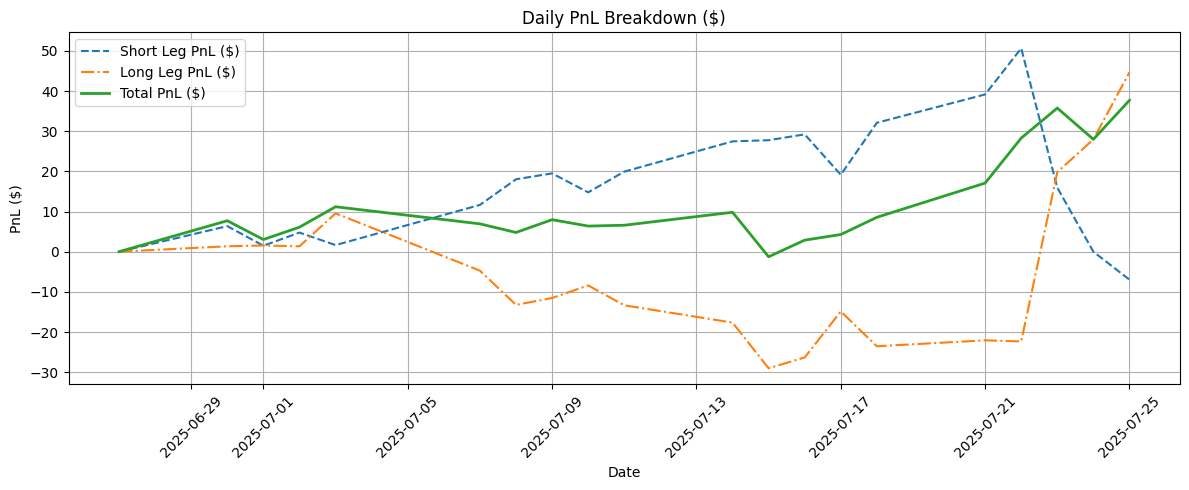

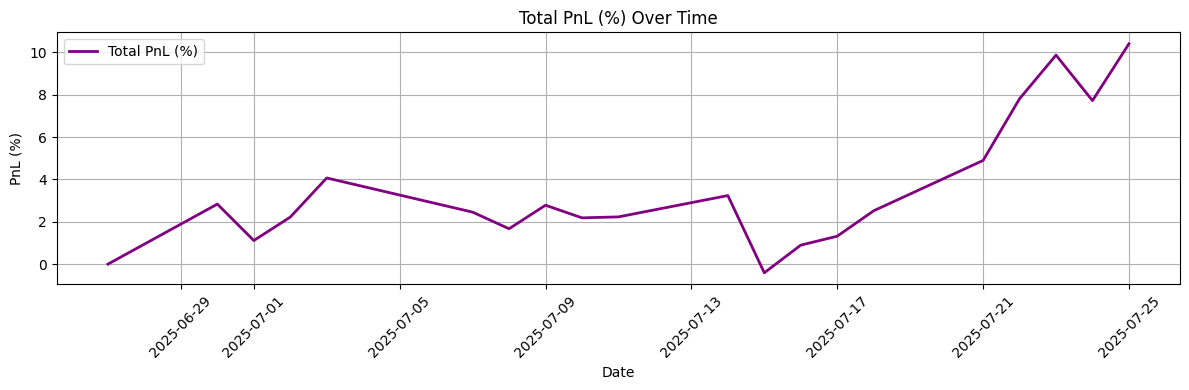

In [ ]:
from matplotlib import pyplot as plt

def plot_pnl_log():
    pnl_df = pd.DataFrame(pnl_log)
    if pnl_df.empty:
        print("‚ö†Ô∏è No PnL data to plot.")
        return

    # First Chart: Absolute PnL
    plt.figure(figsize=(12, 5))
    plt.plot(pnl_df["date"], pnl_df["short"], label="Short Leg PnL ($)", linestyle="--")
    plt.plot(pnl_df["date"], pnl_df["long"], label="Long Leg PnL ($)", linestyle="-.")
    plt.plot(pnl_df["date"], pnl_df["total"], label="Total PnL ($)", linewidth=2)
    plt.title("Daily PnL Breakdown ($)")
    plt.xlabel("Date")
    plt.ylabel("PnL ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Second Chart: Percentage PnL
    if "pct" in pnl_df.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(pnl_df["date"], pnl_df["pct"], label="Total PnL (%)", color="purple", linewidth=2)
        plt.title("Total PnL (%) Over Time")
        plt.xlabel("Date")
        plt.ylabel("PnL (%)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("‚ö†Ô∏è No percent column found in PnL log.")


# Plot PnL at the end
plot_pnl_log()